In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from torchvision import models
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
df = pd.read_csv('/kaggle/input/tpu-getting-started/sample_submission.csv')

In [8]:
df

,id,label
0,b48c962e0,0
1,a13d3dfa4,0
2,94269c190,0
3,bcb18c6e4,0
4,d15a4d94c,0
...,...,...
7377,3744d58d1,0
7378,075602d66,0
7379,b4d954bdc,0
7380,f84335116,0


In [9]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image

In [10]:
def tfrecords_to_dataframe(fp, max_records=2000, test=False, augment=False):  
    def parse_tfrecord(tfrecord, is_test=False):
        features = {
            'id': tf.io.FixedLenFeature([], tf.string),
            'image': tf.io.FixedLenFeature([], tf.string)
        }
        if not is_test:
            features['class'] = tf.io.FixedLenFeature([], tf.int64)
        parsed_features = tf.io.parse_single_example(tfrecord, features)
        return parsed_features

    ids, images, labels = [], [], []
    dataset = tf.data.TFRecordDataset(glob.glob(fp))
    
    for record in dataset.map(lambda x: parse_tfrecord(x, test)):
        ids.append(record['id'].numpy().decode('utf-8'))
        images.append(convert_img_to_np(record['image'].numpy(), augment=augment))  
        if not test:
            labels.append(record['class'].numpy())

    data = {'id': ids, 'img': images}
    if not test:
        data['label'] = labels
        
    return pd.DataFrame(data)

def convert_img_to_np(img, augment=False):
    img = tf.io.decode_jpeg(img, channels=3)
    resized_img = tf.image.resize(img, [128,128])
    if augment:
        resized_img = augment_image(resized_img)
    return resized_img.numpy().astype(np.uint8)

**Loading data and transforming images into numpy array**
Will take ~5 minutes

In [11]:
from tqdm import tqdm


train_imgs, val_imgs, test_imgs = [], [], []
train_labels, val_labels = [], []
test_ids, train_ids = [], []

dim = 224

train_files = f"/kaggle/input/tpu-getting-started/tfrecords-jpeg-{dim}x{dim}/train/*.tfrec"
valid_files = f"/kaggle/input/tpu-getting-started/tfrecords-jpeg-{dim}x{dim}/val/*.tfrec"
test_files  = f"/kaggle/input/tpu-getting-started/tfrecords-jpeg-{dim}x{dim}/test/*.tfrec"

train_df = tfrecords_to_dataframe(train_files, augment=True)
valid_df = tfrecords_to_dataframe(valid_files, augment=False)

for i in tqdm(range(len(train_df))):
    train_imgs.append(train_df['img'][i])
    train_labels.append(train_df['label'][i])

for i in tqdm(range(len(valid_df))):
    val_imgs.append(valid_df['img'][i])
    val_labels.append(valid_df['label'][i])
    
test_df = tfrecords_to_dataframe(test_files, test=True, augment=False)
for i in tqdm(range(len(test_df))):
    test_imgs.append(test_df['img'][i])
    test_ids.append(test_df['id'][i])


num_classes = train_df['label'].nunique()
print(f"Number of classes: {num_classes}")

100%|██████████| 7382/7382 [00:00<00:00, 49474.30it/s]

Number of classes: 104


In [12]:
train_imgs = np.stack(train_imgs, axis=0)
val_imgs = np.stack(val_imgs, axis=0)
test_imgs = np.stack(test_imgs, axis=0)

train_labels = np.stack(train_labels, axis=0)
val_labels = np.stack(val_labels, axis=0)

In [13]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

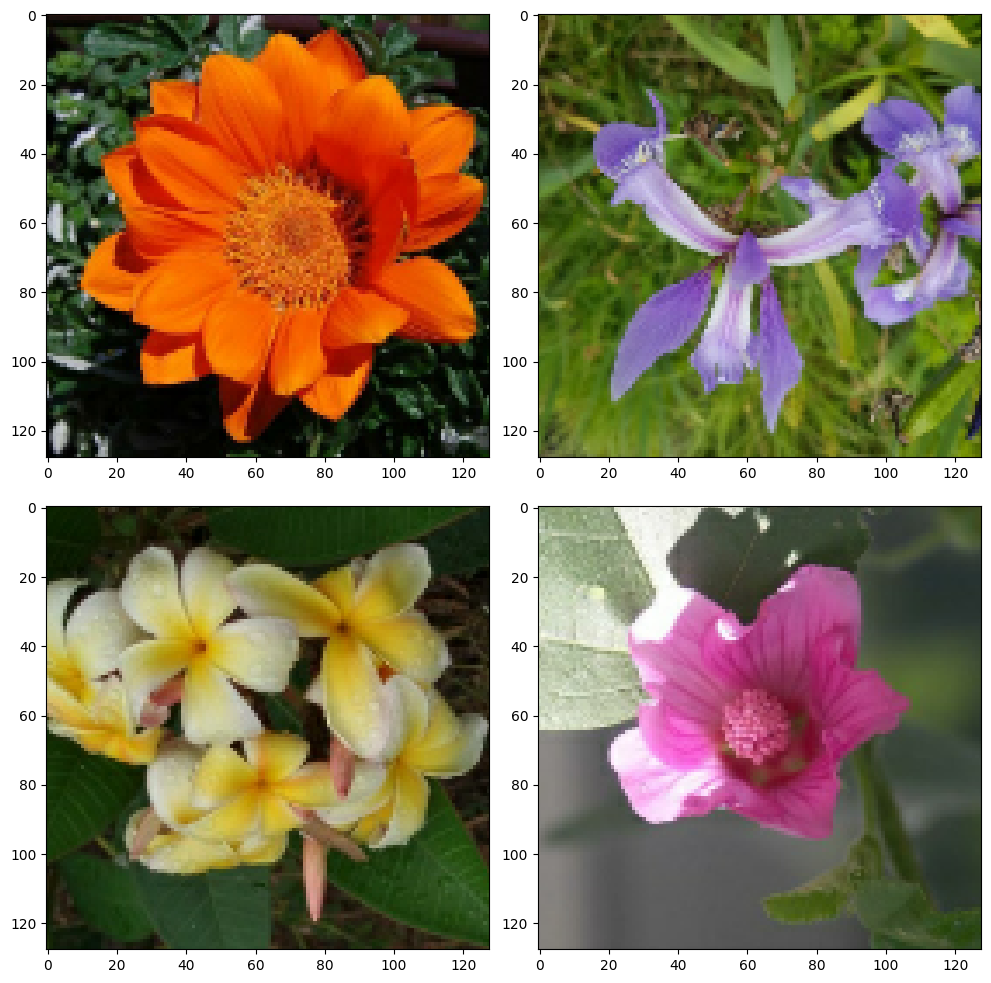

In [14]:
num_images = 4

grid_size = int(np.sqrt(num_images))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
axes = axes.flatten()

for i, img in enumerate(train_imgs[:4]):
    axes[i].imshow(img)

plt.tight_layout()
plt.show()

In [15]:
import torch.nn as nn

class ConvLayer(nn.Module):
    def __init__(self, in_channel, out_channels, kernel_size, stride, padding, dropout_prob = 0.2):
        super().__init__()
        
        assert len(out_channels) == len(kernel_size) == len(stride) == len(padding)
        
        conv_modules = []
        
        for i in range(len(out_channels)):
            in_c = in_channel if i == 0 else out_channels[i - 1]
            conv_module = nn.Conv2d(in_channels=in_c, out_channels=out_channels[i], kernel_size=kernel_size[i], stride=stride[i], padding=padding[i])
            conv_modules.append(conv_module)
        self.impl = nn.Sequential(
            *conv_modules,
            nn.BatchNorm2d(out_channels[-1]),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
        )
    
    def forward(self, input):
        return self.impl(input)


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=7), # output 128 - 7 + 1 = 122x122x6
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # output (122 - (2 - 1)) / 2 + 1 = 61x61x6 (round down)
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5), #output 61 - 5 + 1 = 57x57x12
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #output (57 - (2 - 1)) / 2 + 1 = 29x29x12
            nn.Conv2d(in_channels=12, out_channels=18, kernel_size=5), #output 29 - 5 + 1 = 25x25x18
            nn.BatchNorm2d(18),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #output (25 - (2 - 1)) / 2 + 1 = 13x13x18
        )
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=2592, out_features=2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=104),
        )
        
    def forward(self, input):
        conv_output = self.conv_stack(input)
        flattened_output = torch.flatten(conv_output, start_dim=1)
        return self.linear_stack(flattened_output)

In [16]:
train_imgs[0].shape

(128, 128, 3)

In [17]:
!pip install torchsummary

  Obtaining dependency information for torchsummary from https://files.pythonhosted.org/packages/7d/18/1474d06f721b86e6a9b9d7392ad68bed711a02f3b61ac43f13c719db50a6/torchsummary-1.5.1-py3-none-any.whl.metadata


In [18]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

model = Model().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
loss = nn.CrossEntropyLoss()
net = torch.nn.DataParallel(model, device_ids=[0, 1])
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1) 

In [19]:
from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 122, 122]             888
       BatchNorm2d-2          [-1, 6, 122, 122]              12
              ReLU-3          [-1, 6, 122, 122]               0
         MaxPool2d-4            [-1, 6, 61, 61]               0
            Conv2d-5           [-1, 12, 57, 57]           1,812
       BatchNorm2d-6           [-1, 12, 57, 57]              24
              ReLU-7           [-1, 12, 57, 57]               0
         MaxPool2d-8           [-1, 12, 28, 28]               0
            Conv2d-9           [-1, 18, 24, 24]           5,418
      BatchNorm2d-10           [-1, 18, 24, 24]              36
             ReLU-11           [-1, 18, 24, 24]               0
        MaxPool2d-12           [-1, 18, 12, 12]               0
           Linear-13                 [-1, 2048]       5,310,464
             ReLU-14                 [-

In [20]:
from torch.utils.data import TensorDataset, DataLoader

# Convert training and validation datasets to tensor and wrap them in a TensorDataset
train_dataset = TensorDataset(torch.tensor(train_imgs, dtype=torch.float).permute(0, 3, 1, 2), torch.tensor(train_labels))
val_dataset = TensorDataset(torch.tensor(val_imgs, dtype=torch.float).permute(0, 3, 1, 2), torch.tensor(val_labels))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

In [21]:
def plot_grad_flow(named_parameters):
    avg_grads, max_grads = [], []
    layers = []
    
    for n, p in named_parameters:
        if (p.requires_grad) and "bias" not in n:
            layers.append(n)
            avg_grads.append(p.grad.abs().mean().cpu())
            max_grads.append(p.grad.abs().max().cpu())
    
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(avg_grads)), avg_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(avg_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(avg_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(avg_grads))
    plt.ylim(bottom = -0.001, top=0.02) 
    plt.xlabel("Layers")
    plt.ylabel("average gradient")

In [22]:
training_losses = []
val_losses = []

epochs = 37 

for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    
    for data, targets in train_loader: 
        data, targets = data.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")), targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        optimizer.zero_grad()
        output = model(data)
        loss_output = loss(output, targets)
        running_loss += loss_output.item()
        loss_output.backward()
        optimizer.step()


    avg_train_loss = running_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval() 
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in val_loader: 
            data, targets = data.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")), targets.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            output = model(data)
            loss_val = loss(output, targets)
            val_loss += loss_val.item()
            
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    scheduler.step()
    
    accuracy = correct / total
    print(f'Epoch {epoch}, Training Loss: {running_loss}, Validation Loss: {val_loss}, Accuracy: {accuracy}')

Epoch 0, Training Loss: 55.29128885269165, Validation Loss: 16.19832706451416, Accuracy: 0.08809267241379311
Epoch 1, Training Loss: 46.64276576042175, Validation Loss: 14.210668563842773, Accuracy: 0.13173491379310345
Epoch 2, Training Loss: 43.111576080322266, Validation Loss: 14.541548252105713, Accuracy: 0.1427801724137931
Epoch 3, Training Loss: 40.94981861114502, Validation Loss: 12.908784866333008, Accuracy: 0.1783405172413793
Epoch 4, Training Loss: 39.05353355407715, Validation Loss: 13.696633577346802, Accuracy: 0.1705280172413793
Epoch 5, Training Loss: 37.21691370010376, Validation Loss: 12.68973684310913, Accuracy: 0.19127155172413793
Epoch 6, Training Loss: 35.78098130226135, Validation Loss: 11.476178884506226, Accuracy: 0.24595905172413793
Epoch 7, Training Loss: 33.825857400894165, Validation Loss: 11.316095352172852, Accuracy: 0.2572737068965517
Epoch 8, Training Loss: 32.14772653579712, Validation Loss: 11.273740291595459, Accuracy: 0.26373922413793105
Epoch 9, Train

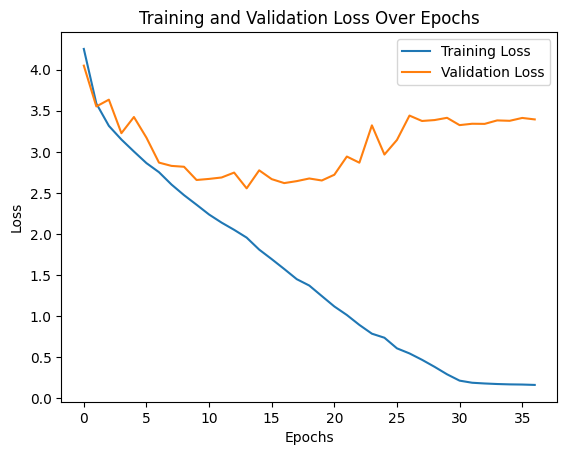

In [23]:
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [24]:
from tqdm import tqdm
predictions = []
batch_size = 256
model = model.to("cuda")
for i in tqdm(range((len(test_imgs) // 256) + 1)):
    start_idx = i * batch_size
    
    test_batch = torch.tensor(test_imgs[start_idx: start_idx + batch_size], dtype=torch.float).cuda()
    test_batch = torch.permute(test_batch, (0, 3, 1, 2))
    
    with torch.no_grad():
        output = model(test_batch)

    prediction = torch.argmax(output, dim=1)
    
    predictions.append(torch.flatten(prediction).tolist())

    

100%|██████████| 29/29 [00:01<00:00, 18.30it/s]


In [25]:
predictions_list = []

for prediction in predictions:
    predictions_list += prediction

In [26]:
print(len(predictions_list), len(test_ids))

7382 7382


In [27]:
prediction_dict = {"id": test_ids, "label": predictions_list}
df = pd.DataFrame(prediction_dict)

In [28]:
df.to_csv("/kaggle/working/submission.csv", index=False)

In [29]:
!pip install torchviz

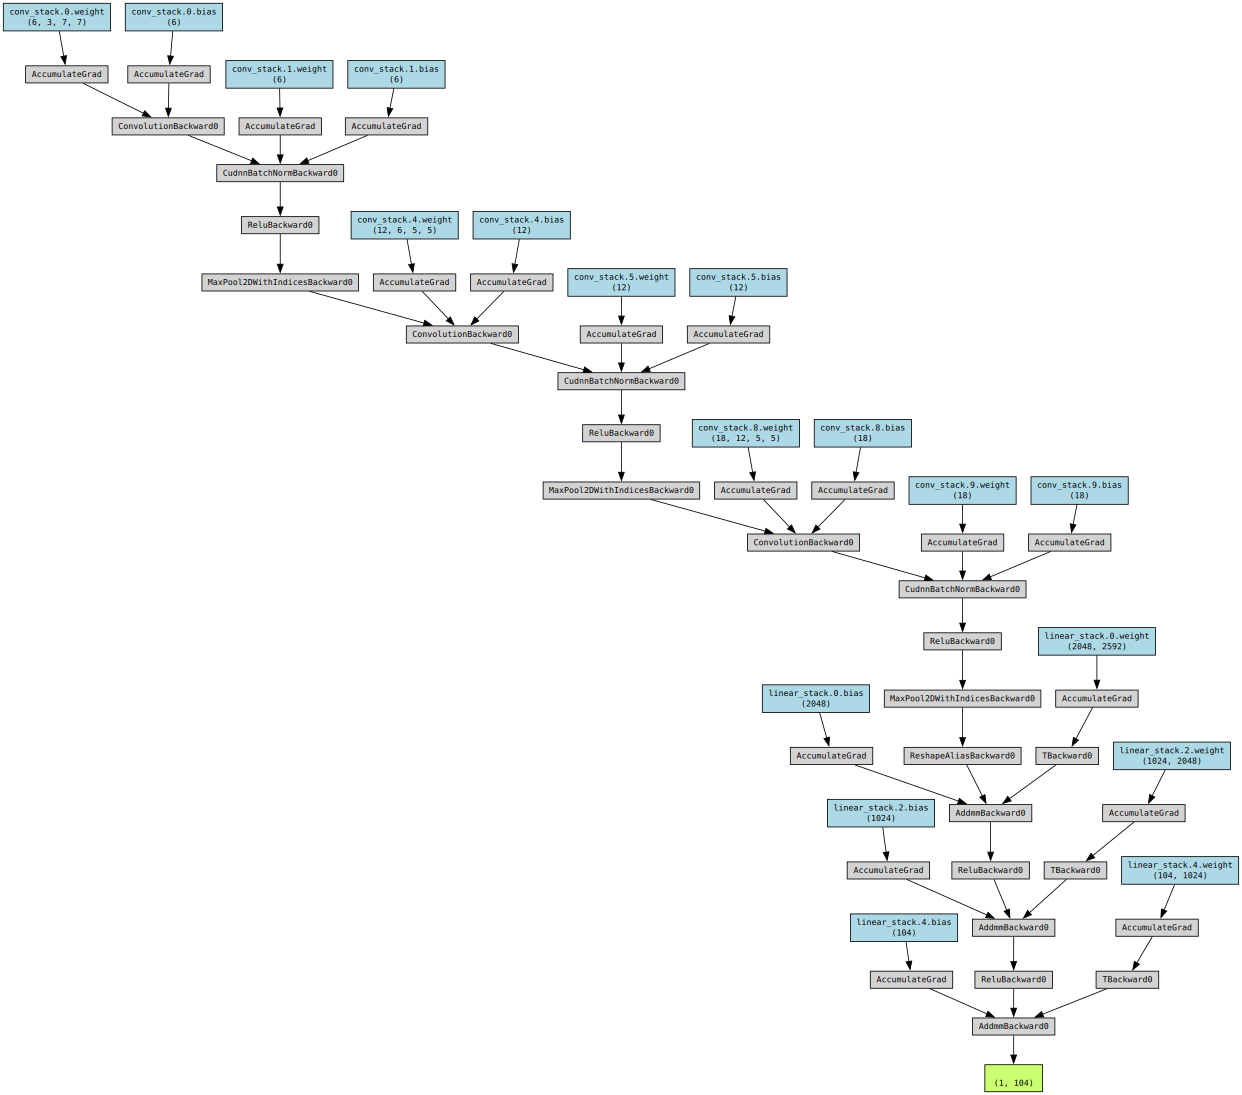

In [31]:
import torch
from torchviz import make_dot

# Assuming 'Model' is your model class and it's already defined
model = Model().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Create a dummy input tensor matching the input shape your model expects
# For the sake of visualization, you can use a single image (batch size = 1)
dummy_input = torch.randn(1, 3, 128, 128).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Perform a forward pass with the dummy input to get the output
output = model(dummy_input)

# Visualize the model
# Note: 'output' is used only to trace the computational graph and is not visualized itself
visual = make_dot(output, params=dict(list(model.named_parameters())))

# Render the visualization
visual.render("model_visualization", format="png", directory="/kaggle/working/")  # Specify your desired directory

# Display the visualization inline (in Jupyter Notebook)
visual